# Deep Glance Classification
Using computer vision and Deep learning, we measure how people feel as they watch videos online through their webcam.

## Computer Vision - B649
### Convolutional Neural Nets - For Gaze Classification
### Authors : 

#### - Arun Nekkalapudi <anekkal@iu.edu>
#### - Aditya Singh Kushwah <akushwah@iu.edu> 
#### - Shreyas Fadnavis <shfadn@iu.edu> 
#### - Khusaal Giri <kngiri@iu.edu>

In [513]:
import os
import cv2
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.python.client import timeline
%matplotlib inline

### Environment Variables - System

In [514]:
IMAGE_PATH = r"D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images" 
IMAGE_LABELS_PATH = r"D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\Emotion"
CONFIG_PATH_OPENCV = r"D:\Uni\Sem 2\CV\CV_Final_Project"
CONFIG_PATH_DATA =   r"D:\Uni\Sem 2\CV\CV_Final_Project\data"

### Environment Variables - Convolutional Neural Net

Configure your convolutional neuralnet over here.

In [580]:
DATA_FEATURES = []
DATA_LABELS = []
LEARNING_RATE = 0.001
ITER_COUNT = 200
BATCH_SIZE = 60
DISPLAY_STEP = 10
CLASS = 8
CHANNELS = 1
IMAGE_SIZE = 224
N_INPUT = IMAGE_SIZE * IMAGE_SIZE
DROPOUT = 0.75

### Filter Weights and Biases 

Modify Filter weights and Biases over here.

In [516]:
filters = {
    'in': tf.Variable(tf.truncated_normal([7,7,CHANNELS,64], stddev=0.01,mean=0), name="F1"),
    '2a': tf.Variable(tf.truncated_normal([1,1,64,96], stddev=0.01,mean=0), name="F2a"),
    '2b': tf.Variable(tf.truncated_normal([3,3,96,208],stddev=0.01,mean=0), name="F2b"),
    '2c': tf.Variable(tf.truncated_normal([1,1,64,64],stddev=0.01,mean=0), name="F2c"),
    '3a': tf.Variable(tf.truncated_normal([1,1,272,96],stddev=0.01,mean=0), name="F3a"),
    '3b': tf.Variable(tf.truncated_normal([3,3,96,208],stddev=0.01,mean=0), name="F3b"),
    '3c': tf.Variable(tf.truncated_normal([1,1,272,64],stddev=0.01,mean=0), name="F3c"),
    'fc': tf.Variable(tf.truncated_normal([272*14*14, 11],stddev=0.01,mean=0), name="FC"),
    'out': tf.Variable(tf.truncated_normal([11, CLASSES],stddev=0.01,mean=0), name="Out")
}

biases = {
    'in': tf.Variable(tf.truncated_normal([64], stddev=0.01,mean=0), name="B1"),
    '2a': tf.Variable(tf.truncated_normal([96], stddev=0.01,mean=0), name="B2a"),
    '2b': tf.Variable(tf.truncated_normal([208],stddev=0.01,mean=0), name="B2b"),
    '2c': tf.Variable(tf.truncated_normal([64],stddev=0.01,mean=0), name="B2c"),
    '3a': tf.Variable(tf.truncated_normal([96],stddev=0.01,mean=0), name="B3a"),
    '3b': tf.Variable(tf.truncated_normal([208],stddev=0.01,mean=0), name="B3b"),
    '3c': tf.Variable(tf.truncated_normal([64],stddev=0.01,mean=0), name="B3c"),
    'fc': tf.Variable(tf.truncated_normal([11],stddev=0.01,mean=0), name="BFC"),
    'out': tf.Variable(tf.truncated_normal([CLASSES],stddev=0.01), name="B_Out")
}

# INFO


*__ How to read FACS code __*

FACS/S005/001/S0005_001_00000011_facs.txt

which has

9.0000000e+00 Â Â 4.0000000e+00
1.7000000e+01 Â Â 2.0000000e+00

this means that AU9d and AU17b are present
N.B if an AU is present but the intensity is 0 this means that the
intensity was not given

e.g.

1.20000000e+00 0.000000000e+00

just means AU12 (intensity not given).

<br />

*__ Classes Available __*

0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise

## 0. Helper functions

In [517]:
# Set image_size = 0 to prevent resiing of the image.
def grayscaleImage(rootPath,imageName,imgSize=IMAGE_SIZE):
    path = os.path.join(rootPath,imageName)
    imgData = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    if(imgSize != 0):
        imgData = cv2.resize(imgData,(imgSize,imgSize))
    return imgData

In [518]:
def saveNumpyState(name,data):
    if(os.path.isfile("/etc/password.txt")):
        os.remove(CONFIG_PATH_DATA,name+'.npy')
    np.save(os.path.join(CONFIG_PATH_DATA,name+'.npy'),data)

## 1. Data Preprocessing

### 1.1. Getting all the faces from the CK+ dataset

In [519]:
# Get faces from each image and train on images w.r.t facial features. 
# Set Output Image size at - environment Variables at the program level. 

# TODO : 1.FileSize has to be fixed.
# 2. Automate  
def getFace(imagePath):
    grayImage = cv2.imread(imagePath,0)
    print(os.getcwd())
    haarFaceCascade = cv2.CascadeClassifier(os.path.join(CONFIG_PATH_OPENCV,'haarcascade_frontalface_alt.xml'))
    detectedFaces = haarFaceCascade.detectMultiScale(grayImage, scaleFactor=1.1, minNeighbors=10)
    
    # Only returns one Image- Can be modified to return multiple images.
    for (x, y, w, h) in detectedFaces:
            r = max(w, h) / 2
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)
            faceImg = grayImage[ny:ny+nr, nx:nx+nr]
            lastImg = cv2.resize(faceImg, (IMAGE_SIZE, IMAGE_SIZE))
            return lastImg

### 1.2. Creating and Processing a testing and training data

In [570]:
def getTrainData(train_path = IMAGE_PATH,labels_path = IMAGE_LABELS_PATH ):
    count = 0
    for root, dirs, files in os.walk(labels_path):
        for filename in [f for f in files if f.endswith(".txt")]:
            arr = filename.split("_")
            count = count + 1
            dirPath = '\\'.join([a for a in arr[:-2]])
            image = getFace(os.path.join(train_path,dirPath,filename.replace('_emotion.txt','.png')))
            f = open(os.path.join(root, filename))
            for line in f:
                line = int(float(line.strip()))
            # One Hot Encoding
            label = []
            oneHot = np.zeros(CLASS)
            oneHot[line] = 1.0
            DATA_LABELS.append(oneHot)
            DATA_FEATURES.append(image)
    print(count)
    saveNumpyState("features",DATA_FEATURES)
    saveNumpyState("labels",DATA_LABELS)

In [521]:
getTrainData()

D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset

D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset

D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset

D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset 4 - cmu\extended-cohn-kanade-images\cohn-kanade-images
D:\Uni\Sem 2\CV\datasets\Dataset

## 2. Loading Processed Data

In [522]:
# Load processed data
feature = np.load(os.path.join(CONFIG_PATH_DATA,'features.npy'))
labels = np.load(os.path.join(CONFIG_PATH_DATA,'labels.npy'))

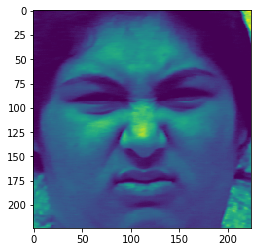

In [523]:
feature[1].shape
plt.imshow(feature[0])

In [538]:
labels[0]  # One Hot Encoding

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [540]:
print(len(feature))

327


## 3. Setting up the Convolution Environment

### 3.1. Convolution Layer

DocLink : <https://www.tensorflow.org/api_docs/python/tf/nn/conv2d>

In [525]:
# X = Input, w = Weight, b = Bias 
def conv2D(X,w,b, strides = 1, padding = 0,layerName = "convLayer"):
    if (padding != 0):
        X = tf.pad(X, [[0,0],[padding,padding],[padding,padding],[0,0]])
    X = tf.nn.conv2d(X,w, strides=[1,strides,strides,1],padding = "VALID" , name = layerName)
    X = tf.nn.bias_add(X,b)
    return tf.nn.relu(X)

### 3.2. Max-Pooling Layer
*DocLink :* <https://www.tensorflow.org/api_docs/python/tf/nn/max_pool>

In [526]:
def maxPool(X,k,strides = 1, padding = 0,layerName = "maxPool"):
     if (padding != 0):
        X = tf.pad(X, [[0,0],[padding,padding],[padding,padding],[0,0]])
     return tf.nn.max_pool(X, ksize=[1,k,k,1], strides=[1,strides,strides,1], padding='VALID')   

### 3.3. Convolutional Neural Net - Design

__* <<< This architecture is based on the reference to one of the paper mentioned in the document. >>>*__

In [527]:
def convNet(x, filters, bias, dropout):
    x = tf.reshape(x, shape=[-1, IMAGE_SIZE, IMAGE_SIZE, 1])
   
    # INPUT
    conv1 = conv2D(x, filters['in'], bias['in'], strides=2, padding=3, layerName="CONV1")
    pool1 = maxPool(conv1, k=3, strides=2, padding=1)
    lrn = tf.nn.lrn(pool1)
    
    # HIDDEN LAYER 1
    conv2a = conv2D(lrn, filters['2a'], bias['2a'], strides=1, padding=0, layerName="CONV2A")
    pool2a = maxPool(lrn, k=3, strides=1, padding=1)
    
    # HIDDEN LAYER 2B 
    conv2b = conv2D(conv2a, filters['2b'], bias['2b'], strides=1, padding=1, layerName="CONV2B")
    # HIDDEN LAYER 2C
    conv2c = conv2D(pool2a, filters['2c'], bias['2c'], strides=1, padding=0, layerName="CONV2C")
    # CONCATENATE 2B AND 2C
    concat2 = tf.concat([conv2b, conv2c],3)
    # Pooling 2B
    pool2b = maxPool(concat2, k=3, strides=2, padding=1)
    
    # HIDDEN LAYER 3A
    conv3a = conv2D(pool2b, filters['3a'], bias['3a'], strides=1, padding=0, layerName="CONV3A")
    # HIDDEN LAYER 3A
    pool3a = maxPool(pool2b, k=3, strides=1, padding=1)
    
    # HIDDEN LAYER 3B
    conv3b = conv2D(conv3a, filters['3b'], bias['3b'], strides=1, padding=1, layerName="CONV3B")
    # HIDDEN LAYER 3C
    conv3c = conv2D(pool3a, filters['3c'], bias['3c'], strides=1, padding=0, layerName="CONV3C")
    # CONCATENATE 3B AND 3C
    concat3 = tf.concat([conv3b, conv3c],3)
    # POOLING 3B
    pool3b = maxPool(concat3, k=3, strides=2, padding=1)
    
    # CREATING A FULLY CONNECTED LAYER
    pool_shape = pool3b.get_shape().as_list()
    fc = tf.reshape(
        pool3b, [-1, pool_shape[1] * pool_shape[2] * pool_shape[3]]
    )
    fc = tf.add(tf.matmul(fc, filters['fc']), bias['fc'])
    
    # APPLY DROPOUT 
    fc = tf.nn.dropout(fc, dropout)
    
    # OUTPUT
    out = tf.add(tf.matmul(fc, filters['out']), bias['out'])
    
    return out

In [533]:
# Features
X = tf.placeholder(tf.float32,[None,N_INPUT],name="X_Input")
y = tf.placeholder(tf.float32,[None,CLASS],name = "y_out")
keep_prob = tf.placeholder(tf.float32)
saver = tf.train.Saver()

In [534]:
# Contruct Model
out = convNet(X, filters, biases, keep_prob)

In [535]:
# Define Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

In [536]:
# Defining Accuracy 
# predicted = tf.argmax(out, 1)
# actual = tf.argmax(y, 1)

trueCount = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(trueCount, tf.float32))

# Variables Initialization
init0 = tf.global_variables_initializer()
init1 = tf.local_variables_initializer()

In [543]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [581]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run([init0,init1])
    accuIter,costIter,accTemp,costTemp = [] ,[],[],[]
    for iter in range(ITER_COUNT):
        for num in range(int(len(feature)/BATCH_SIZE)) :
            if num*BATCH_SIZE+BATCH_SIZE <= len(feature):
                end = num*BATCH_SIZE+BATCH_SIZE
            else:
                end = len(feature)

            x1 = np.array(feature[BATCH_SIZE*num:end]).reshape(-1, N_INPUT)
            y1 = np.array(labels[BATCH_SIZE*num:end]).reshape(-1, CLASSES)
            loss, opt, acc = sess.run([cost, optimizer, accuracy], feed_dict={X:x1 , y: y1, keep_prob: DROPOUT})
            costIter.append(loss)
            accuIter.append(acc)
            accTemp.append(acc)
            costTemp.append(loss)
            avgAcc = sum(accTemp)/len(accTemp)
            avgCost = sum(costTemp)/len(costTemp)
        if (iter%DISPLAY_STEP == 0):
            print("Iteration: %d " % iter, " Accuracy: %.5f" % avgAcc , "Cost: %.5f" % avgCost)   

Iteration: 0   Accuracy: 0.18413 Cost: 2.04699
Iteration: 10   Accuracy: 0.24416 Cost: 1.87422
Iteration: 20   Accuracy: 0.24883 Cost: 1.84856
Iteration: 30   Accuracy: 0.25264 Cost: 1.83912
Iteration: 40   Accuracy: 0.25590 Cost: 1.83225
Iteration: 50   Accuracy: 0.25565 Cost: 1.82767
Iteration: 60   Accuracy: 0.25678 Cost: 1.82445
Iteration: 70   Accuracy: 0.25786 Cost: 1.82149
Iteration: 80   Accuracy: 0.25840 Cost: 1.81914
Iteration: 90   Accuracy: 0.25885 Cost: 1.81736
Iteration: 100   Accuracy: 0.25931 Cost: 1.81589
Iteration: 110   Accuracy: 0.25957 Cost: 1.81443
Iteration: 120   Accuracy: 0.25971 Cost: 1.81324


KeyboardInterrupt: 